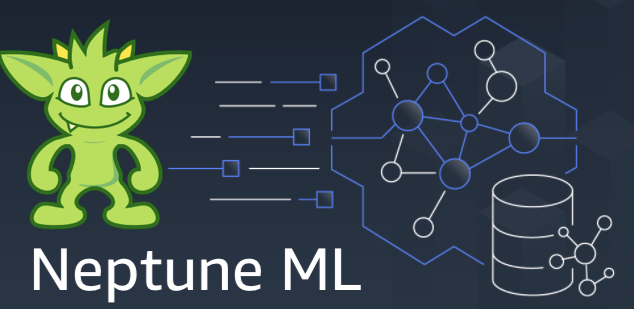

# Getting started with Neptune ML
This notebook provides an overview of the Amazon Neptune ML feature and how you can use it in a property graph to infer missing data.  All that you will need to have available to run this tutorial is an Amazon Neptune Cluster with Neptune ML enabled and an S3 bucket in the same region.  


<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This tutorial will cost ~$2-3/hour in addition to the cost of your Neptune cluster and will take approximately 30 minutes to complete</div>


Graphs and graph data is all about using the values and connections within that data to provide novel insight.  However one common issue with graph data is that it is frequently incomplete, meaning that it contains missing property values or connections.  While incomplete data is not unique to graphs the connected nature how we want to use graph data makes these gaps even more impactful, usually lead to inefficent traversals and/or incorrect results.  Neptune ML was released to help mitigate these issues by integrating Machine Learning (ML) models into real time graph traversals to predect/infer missing graph elements such as properties and connections.  

[Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview) is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of Graph Neural Network (GNN) machine learning models within Amazon Neptune.  Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) and provides a simple and easy to use mechanism to build/train/maintain these models and then use the predictive capabilities of these models within a Gremlin query to predict elements or property values in the graph. These models cover many common use cases such as:

* [Identifying fradulent transactions](https://aws.amazon.com/blogs/machine-learning/detecting-fraud-in-heterogeneous-networks-using-amazon-sagemaker-and-deep-graph-library/)
* Predicting group membership in a social or identity network
* Predicting categories for product recommendation
* Predicting user churn

Neptune ML accomplishes this by providing the ability to perform several common machine learning tasks within Neptune using the Gremlin query language.  These tasks include:

* **Node Classification** - The ability to predict a property value from a finite set of options.  Node classification can be used for situations such as determining if a transaction is fraudulent, detemining what sort or product a person is most likely to purchase, or predicting a persons age or occupation.
* **Node Regression** - The ability to predict a numerical property value such as a user's credit score or how a person might rate a movie.
* **Link Prediction** - The ability to predict an edge between two vertices.  This can be used to solve problems such as finding friends within a social network, recommending products to a user, or determining if a person is a member of a fraud ring. 
* **Edge Classification** - The ability to predict a property value from a finite set of options.  Edge classification can be used for situations such as determining if a transaction is fraudulent, detemining what sort or product a person is most likely to purchase, or predicting a persons age or occupation.
* **Edge Regression** - The ability to predict a numerical property value such as a user's credit score or how a person might rate a movie.

To accomplish this in Neptune ML we use a four step process:

1. **Load Data** - Data is loaded into a Neptune cluster using any of the normal methods such as the Gremlin drivers or using the Neptune Bulk Loader.
2. **Export Data** - A service call is made specifying the machine learning model type and model configuration parameters.  The data and model configuration parameters are then exported from a Neptune cluster to an S3 bucket.
3. **Model Training** - A set of service calls are made to pre-process the exported data, train the machine learning model, and then generate an Amazon SageMaker endpoint that exposes the model.  Neptune ML achieves this by automating the normal machine learning process of dividing data into training, validation, and test sets.  It then  uses training dataset is used to build the model, the validation dataset to validate the model and determine which of the best model, and then estimate the model's accuracy using the test dataset.  Using these steps Neptune ML simplifies the overall model building process by automatically returning the best model possible for the configuration provided.
4. **Run Queries** - The final step is to use this inference endpoint within our Gremlin queries to infer data using the machine learning model.

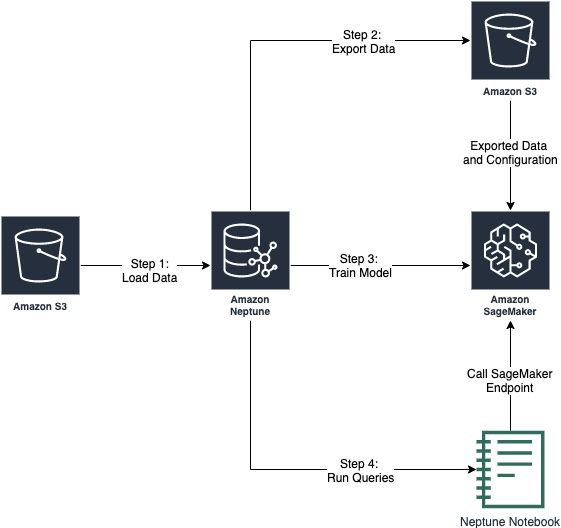

Running through this process can take quite awhile (e.g. hours) to complete. To speed up your ability to try out each of this feature we've provided a set of pretrained models for use with this notebook. These pretrained models eliminate the need for you to perfom most of the long running steps (Export, Data Processing, and Model training) but will still allow you to see the end benefits of inferring data during Gremlin queries.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: To run through these steps yourself use one of the five "Introduction to (Node Classification/Node Regression/Link Prediction/Edge Classification/Edge Regression)" notebooks, located in the 04-Machine-Learning directory, that matches your use case.</div>

These pre-trained models use the [MovieLens 100k dataset](https://grouplens.org/datasets/movielens/100k/) provided by [GroupLens Research](https://grouplens.org/datasets/movielens/). This dataset consists of movies, users, and ratings of those movies by users. 

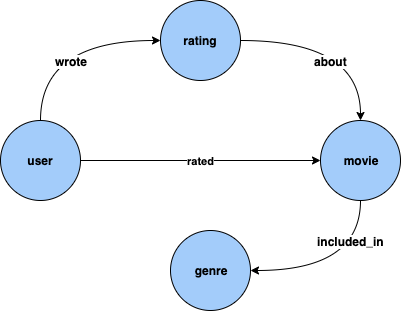

## Checking that we are ready to run Neptune ML 
Run the code below to check that your cluster is configured to run Neptune ML.

In [ ]:
import neptune_ml_utils as neptune_ml
neptune_ml.check_ml_enabled()

If the check above did not say that this cluster is ready to run Neptune ML jobs then please check that the cluster meets all the pre-requisites defined [here](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview).

## Loading data 

The first step in building a Neptune ML model is to load data into the Neptune cluster. Loading data for Neptune ML follows the standard process of ingesting data into Amazon Neptune, for this example we'll be using the Bulk Loader. 

We have written a script that automates the process of downloading the data from the MovieLens websites and formatting it to load into Neptune. All you need to provide is an S3 bucket URI that is located in the same region as the cluster.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This is the only step that requires any specific input from the user, all remaining cells will automatically propogate the required values.</div>

In [ ]:
s3_bucket_uri="s3://<INSERT S3 BUCKET OR PATH>"
# remove trailing slashes
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

Now that you have provided an S3 bucket, run the cell below which will download and format the MovieLens data into a format compatible with Neptune's bulk loader.

In [ ]:
response = neptune_ml.prepare_movielens_data(s3_bucket_uri)

This process only takes a few minutes and once it has completed you can load the data using the `%load` command in the cell below.

In [ ]:
%load -s {response} -f csv -p OVERSUBSCRIBE --run


## Configuring the Endpoints

Now that we have confirmed that our cluster is setup for Neptune ML let's create our endpoints for each model type from our pre-trained models.  As we stated, we have provided a set of pretrained models, one for each model type provided by Neptune ML.  When you generate a model there are a few key items to understand:

* Each model is trained to perform one task only.  e.g. Node classifcation, node regression, link prediction, edge classification, and edge regression will each be their own model
* For node classification, node regression, edge classification, and edge regression the property you want to infer is specified at the time the model is built, this is the only property that model can infer.
* The models only work on elements of the graph that existed at the time the model was built, known as a transductive model.  Newly added elements cannot be used until the model is retrained or the model has been transformed to work against newly added data as well.

Each of these models is trained and configured to allow for performing a specific task.

Node Classification - This model is trained to allow for inferring the `genre` property of a `movie` node.
Node Regression - This model is trained to allow for inferring the `score` property of a `rating` node.
Link Prediction - This model will be used to infer `rated` edges between a `user` node and a `movie` node.
Edge Classification - This model is trained to allow for inferring the `scale` property of a `rated` edge.
Edge Regression - This model is trained to allow for inferring the `score` property of a `rated` edge.

To simplify setting this up we have provided some python code below to load the MovieLens data into the Neptune Cluster and setup the five endpoints.  With this code there are several configuration options you can choose:

* Each task type is configured to be created by default.  If you would like to not setup one or more task types then please set the variable to `False` for that task. e.g. To not create a node classification endpoint set `setup_node_classification=False`
* Each endpoint created has an associated hourly charge so please ensure you delete them when finished, either using the `Cleaning Up` cell below or via the Amazon Web Services Console -> Amazon SageMaker -> Endpoints.

In the cell below you need to provide an S3 bucket that will be used to maintain the model artifacts.  After you have configured the cell below, run the cell, and the associated endpoints will be created.  This will take 5-10 minutes to complete.  

In [ ]:
setup_node_classification=True
setup_node_regression=True
setup_link_prediction=True
setup_edge_classification=True
setup_edge_regression=True

endpoints=neptune_ml.setup_pretrained_endpoints(s3_bucket_uri, setup_node_classification, setup_node_regression, setup_link_prediction, setup_edge_classification, setup_edge_regression)

In [ ]:
node_classification_endpoint=endpoints['node_classification_endpoint_name']['EndpointName']
node_regression_endpoint=endpoints['node_regression_endpoint_name']['EndpointName']
link_prediction_endpoint=endpoints['prediction_endpoint_name']['EndpointName']
edge_classification_endpoint=endpoints['edge_classification_endpoint_name']['EndpointName']
edge_regression_endpoint=endpoints['edge_regression_endpoint_name']['EndpointName']

Once this cell has completed we have the endpoint names for our newly created inference endpoints, which will be used in the configuration of each Gremlin query.  

In your use case the models will require configuration and training parameter adjustments to maximize the accuracy of the inferences they generate.  These pretrained models use the default parameters to demonstrate the base accuracy of the models prior to tuning.  Additional information on how to tune these models via the links below:

* [Training File Configuration](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-processing-training-config-file.html)
* [Tuning Hyperparameters](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-customizing-hyperparams.html)
* [Improving Model Performance](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-improve-model-performance.html)

# Querying using Gremlin

Now that we have built our inference endpoints constructed let's see how we can use these to infer data within our Gremlin queries.  Let's start with node classification.

## Node Classification
Node classification is the ability to infer missing property data from a finite set of options.  Now that we have our inference endpoint setup let's query our product knowledge graph to show how to predict categorical property values by predicting the the genre for our new movies, starting with `Forrest Gump`.  

Before we predict the movie's genre let's verify that our graph does not contain any `genre` values for the `genre` of the `movie` *Forrest Gump*.

In [ ]:
%%gremlin
g.V().has('title', 'Forrest Gump (1994)').properties("genre").value()

As expected this returned no values, so let's modify this query to predict the genre for `Apollo 13`.  To accomplish this we need to add two steps to the query above that let's it know to use Neptune ML to find the value.

First, we add the `with()` step to specify the inference endpoint we want to use with our Gremlin query like this
`g.with("Neptune#ml.endpoint","<INSERT ENDPOINT NAME>")`.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The endpoint values are automatically passed into the queries below</div>

Second, when we ask for the property within our query we use the `properties()` step with an additional `with()` step (`with("Neptune#ml.classification")`) which specifies that we want to retrieve the predicted value for this property.

Putting these items together we get the query below, which will predict `genre` for the `Forrest Gump` movie in our product knowledge graph.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${node_classification_endpoint}").
  V().has('title', 'Forrest Gump (1994)').properties("genre").with("Neptune#ml.classification").value()

Looking at the results, this prediction seems right, `Forrest` seems to fit well into the `Drama` genre.  

In many situations, you may want to predict multiple categories for a node.  For example, in our product knowledge graph a movie is likely to belog to multiple genres so we'll want to predict these multiple genres.  By default Neptune ML returns the top result, but we specify the number of results to return using the `.with("Neptune#ml.limit",3)` configuration option.  Let's take a look at the top 3 predicted genres for `Forrest Gump`.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${node_classification_endpoint}").
  with("Neptune#ml.limit",3).
  V().has('title', 'Forrest Gump (1994)').properties("genre").with("Neptune#ml.classification").value()

Each value returned by Neptune ML has a confidence score associated with it and the query above returns the top three results, no matter the confidence in the prediction. While this score is not available at query time it can be used to filter out predictions with a low confidence.  

Let's say that we wanted to return the top 3 genres for `Forrest Gump` but only if the prediction has a specific confidence.  We add this filter to the query above using the `.with("Neptune#ml.threshold",0.2D)` option such as shown below.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${node_classification_endpoint}").
  with("Neptune#ml.limit",3).with("Neptune#ml.threshold",0.2D).
  V().has('title', 'Forrest Gump (1994)').properties("genre").with("Neptune#ml.classification").value()

As we see, we are now only getting the predicted genre of `Drama` as it is the only prediction above the threshold.

So far we have only been working on a single movie, but let's say you wanted to predict the genre for all movies without a `genre`, we can accomplish this using the query below.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${node_classification_endpoint}").
    V().hasLabel('movie').hasNot('genre').
    project('title', 'predicted_genre').
        by('title').
        by( properties("genre").with("Neptune#ml.classification").value()).
    order(local).by(keys, desc)

We can also apply the same filters shown above to this query to find the top 3 genres for all our "new" movies, as long as the prediction above a specfic confidence.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${node_classification_endpoint}").
    with("Neptune#ml.limit", 3).
    with("Neptune#ml.threshold", 0.2D).
    V().hasLabel('movie').hasNot('genre').
    project('title', 'predicted_genre').
        by('title').
        by(properties("genre").with("Neptune#ml.classification").value().fold()).
    order(local).by(keys, desc)

Now that we have taken a look at the basics of node classification, let's move on to take a look at our next type of Neptune ML task, node regression.

## Node Regression

Node regression is the ability to infer missing property data where that data is a numerical value. The need to predict rating values in a product knowledge graph is commonly used to provide recommendations for products that a customer might want by predicting the products they will rate highest.

For our pretrained models this means we can infer the `score` of `rating` vertices. To demonstrate this let's use our newly created node regression endpoint to see what rating score `user_1` will give to each movie they have rated.

Before we predict `user_1` movie ratings let's verify that our graph does not contain any `score` values for movies for `user_1`.

In [ ]:
%%gremlin
g.V('user_1').out('wrote').
    project('movie', 'score').
        by(out('about').values('title')).
        by(coalesce(properties("score").value(), constant(-999)))

As expected this returned no `score` values, so let's modify this query to predict the `score` that `user_1` will give each movie. To accomplish this we need to add two steps to the query above that let's it know to use Neptune ML to find the value.

First, we add the `with()` step to specify the inference endpoint we want to use with our Gremlin query like this
`g.with("Neptune#ml.endpoint","<INSERT ENDPOINT NAME>")`.  

Second, when we ask for the property within our query we use the `properties()` step with an additional `with()` step (`with("Neptune#ml.regression")`) which specifies that we want to retrieve the predicted value for this property.

Putting these items together we get the query below, which will predict the rating `score` that `user_1` will give to each movie.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${node_regression_endpoint}").
  V('user_1').out('wrote').
    project('movie', 'score').
        by(out('about').values('title')).
        by(properties("score").with("Neptune#ml.regression").value())

With this configuration specified we now see that we are getting the inferred values for the `score` back for each `rating` node.  If we take the query from above and add a bit of ordering and filtering we get the query below, we can get answer common queries such as providing us with the top 10 movie recommendations for `user_1`.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${node_regression_endpoint}").
  V('user_1').out('wrote').
    project('movie', 'score').
        by(out('about').values('title')).
        by(properties("score").with("Neptune#ml.regression").value()).
    order().by('score', desc).limit(10)

Now that we've seen how node regression, let's move on to the next Neptune ML task, link prediction.

## Link Prediction

Link prediction is the ability to infer edges between two vertices in our graph. Unlike node classification and node regression, link prediction can infer any of the edge labels that existed in our graph when the model was created.  In our model this means we could infer the probability that a `wrote`, `about`, `rated`, or `included_in` edge exists between any two vertices.  However for this example we are going to focus on inferring the `rated` edges between the `user` and `movie` vertices. 

To demonstrate this let's predict what movies a user will rate by finding predictions for `rated` edges for `user_1`.

In [ ]:
%%gremlin
g.V('user_1').out('rated').hasLabel('movie').valueMap()

As expected, their are not any `rated` edges for `user_1`.  Maybe `user_1` is a new user in our system and we want to provide them some product recommendations.  Let's modify the query to predict what movies `user_1` is most likely to rate. 

First, we add the `with()` step to specify the inference endpoint we want to use with our Gremlin query like this
`g.with("Neptune#ml.endpoint","<INSERT ENDPOINT NAME>")`.  

Second, when we ask for the link within our query we use the `out()` step to predict the target node or the `in()` step to predict the source node.  For each of these steps we need to specify the type of model being used with a with() step (`with("Neptune#ml.prediction")`).

Putting these items together we get the query below, which returns the movies that` user_1` is likely to rate.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${link_prediction_endpoint}").
    V('user_1').out('rated').with("Neptune#ml.prediction").hasLabel('movie').valueMap('title')

Great, we can now see that we are predicted edges showing the movie that user_1 is most likely to rate. In the example above we predicted the target node but we can also use the same mechanism to predict the source node.

Let's turn that question around and say that we had a product and we wanted to find the people most likely to rate this product.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${link_prediction_endpoint}").
    with("Neptune#ml.limit",10).
      V().has('title', 'Forrest Gump (1994)').
        in('rated').with("Neptune#ml.prediction").hasLabel('user').id()

With that we have sucessfully been able to show how you can use link prediction to predict edges starting at either the incoming or outgoing node.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", "${link_prediction_endpoint}").
  V('user_1').
  out('rated').with("Neptune#ml.prediction").
  hasLabel('movie').
  out('included_in').
  path().by(id()).by(values('title')).by(id())

As we can see the values returned include the path from `user_1` to the movie `Good Morning (1971)` to a genre for that movie called `unknown`.  Now that we've seen how link prediction, let's move on to the next Neptune ML task, edge classification.

## Edge Classifcation

Edge classification is the ability to infer missing property data from a finite set of options. Now that we have our inference endpoint setup let's query our product knowledge graph to show how to predict categorical property values on edges by predicting how much a user likes a movie.

One of the common things you might want to do with a product knowledge graph is to provide recommendations for products for a user. In our product knowledge graph we can use Neptune ML to make this prediction for `user_2` by finding all the `scale` values for `user_2`.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", '${edge_classification_endpoint}').
  V('user_2').
  outE('rated').
    project('title', 'predicted_scale').
        by(inV().values('title')).
        by(properties('scale').with("Neptune#ml.classification").value())

However in many cases you will likely only want to provide predictions for products a user will love.  In our product know graph we can do that by limiting the results of our prediction on scale to only the values of `Love`.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", '${edge_classification_endpoint}').
  V('user_2').
  outE('rated').as('r').
  properties('scale').with("Neptune#ml.classification").
  value().
  is('Love').
  select('r').
  inV().
  values('title')

Looking at the results we see that we predict that `user_2` will `Love` 6 movies.

In the query above we are asking for the predicted results for scale but we have no idea how sure we are of that prediction. Let's say that we wanted to return the movies `user_2` will `Love` but only if the confidence is above a certain threshold. We add this filter to the query above using the `.with("Neptune#ml.threshold",0.35D)` option such as shown below.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", '${edge_classification_endpoint}').
    with("Neptune#ml.threshold", 0.35D).
  V('user_2').
  outE('rated').as('r').
  properties('scale').with("Neptune#ml.classification").
  value().
  is('Love').
  select('r').
  inV().
  values('title')

Now that we've seen how to use edge classification in Neptune ML to predict the top movie recommendations for our user, let's move on to the last task in Neptune ML, edge regression.

## Edge Regression
Edge regression is the ability to infer missing property data where that data is a numerical value. The need to predict rating values in a product knowledge graph is commonly used to provide recommendations for products that a customer might want by predicting the products they will rate highest.

For our pretrained models this means we can infer the `score` of `rated` edges. To demonstrate this let's use our newly created edge regression endpoint to see what rating score `user_1` will give to each movie they have `rated`.

Before we predict `user_1 movie ratings let's verify that our graph does not contain any score values for movies for user_1.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", '${edge_regression_endpoint}').
  V('user_2').
  outE('rated').
    project('title', 'predicted_score').
        by(inV().values('title')).
        by(properties('score').with("Neptune#ml.regression").value())

However in many cases you will likely only want to provide predictions for products a user will rate highly. In our product know graph we can do that by limiting the results of our prediction to only the top 10 movie recommendations.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", '${edge_regression_endpoint}').
  V('user_2').
  outE('rated').
    project('title', 'predicted_score').
        by(inV().values('title')).
        by(properties('score').with("Neptune#ml.regression").value()).
    order().by('predicted_score', desc).limit(10)

Looking at the results we see the top 10 movie predictions for `user_2` with the predicted rating score.

# Cleaning Up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.


In [ ]:
neptune_ml.delete_pretrained_endpoints(endpoints)

In addition to the inference endpoint the CloudFormation script that you used has setup several additional resources.  If you are finished then we suggest you delete the CloudFormation stack to avoid any recurring charges. For instructions, see [Deleting a Stack on the Amazon Web Services CloudFormation Console](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/cfn-console-delete-stack.html). Be sure to delete the root stack (the stack you created earlier). Deleting the root stack deletes any nested stacks.